Original Class Distribution:
 Label
Entertainment    44834
Technology       30107
Business         24834
Health           12020
Name: count, dtype: int64


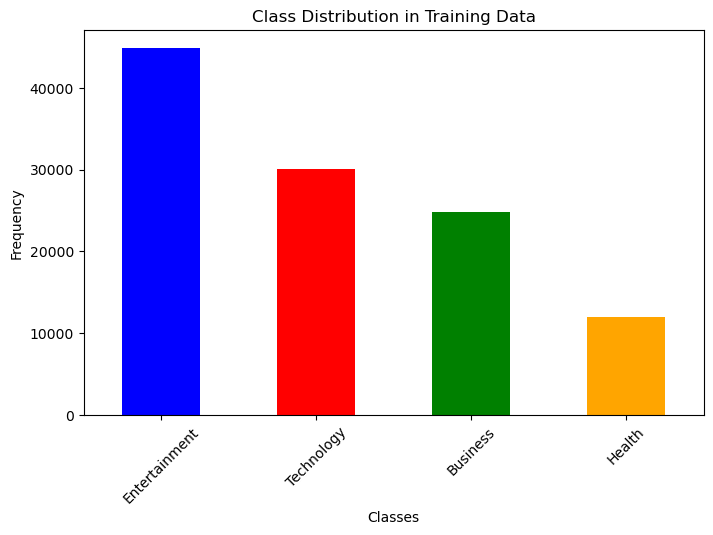

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
import sys
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt

# Load dataset
train_df = pd.read_csv("train.csv")

# Check the class distribution
class_counts = train_df['Label'].value_counts()
print("Original Class Distribution:\n", class_counts)

# Plot class distribution
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['blue', 'red', 'green', 'orange'])
plt.title("Class Distribution in Training Data")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [2]:
# Find the minimum class count (smallest category size)
min_samples = train_df['Label'].value_counts().min()

# Create a balanced dataset by sampling min_samples from each class
balanced_df = train_df.groupby('Label').apply(lambda x: x.sample(min_samples, random_state=42)).reset_index(drop=True)

# Check new distribution
print("Balanced Class Distribution:\n", balanced_df['Label'].value_counts())

# Save the balanced dataset for future use
balanced_df.to_csv("balanced_train.csv", index=False)
print("Balanced dataset saved as balanced_train.csv!")

Balanced Class Distribution:
 Label
Business         12020
Entertainment    12020
Health           12020
Technology       12020
Name: count, dtype: int64


/var/folders/rf/mrtbxhpn4tqdglcfpw6yhb4w0000gn/T/ipykernel_34710/3426988539.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = train_df.groupby('Label').apply(lambda x: x.sample(min_samples, random_state=42)).reset_index(drop=True)


Balanced dataset saved as balanced_train.csv!


In [5]:
# Load balanced dataset instead of the original one
train_df = pd.read_csv("balanced_train.csv")

# Load the test dataset
test_unlabeled_df = pd.read_csv("test_without_labels.csv")

print(f"Balanced Training Data: {train_df.shape} rows")
print(f"Test Data: {test_unlabeled_df.shape} rows")

Balanced Training Data: (48080, 4) rows
Test Data: (47912, 3) rows


In [7]:
# Text Preprocessing Function
def preprocess_text(text):
    if pd.isnull(text):  # Handle NaN values
        return ""
    
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation and numbers
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    
    return ' '.join(tokens)

# Function to preprocess entire dataset
def preprocess_dataset(df, text_columns):
    for col in text_columns:
        df[col] = df[col].astype(str).apply(preprocess_text)
    return df

print("Preprocessing functions are ready!")

Preprocessing functions are ready!


In [9]:
# Apply preprocessing
text_columns = ['Title', 'Content']
print("Preprocessing text data...")

for col in text_columns:
    print(f"\nProcessing column: {col}")
    
    total_rows = len(train_df) + len(test_unlabeled_df)  # Total rows to process
    processed_rows = 0  # Track processed rows

    # Process training data
    for i in range(len(train_df)):
        train_df.at[i, col] = preprocess_text(str(train_df.at[i, col]))
        processed_rows += 1
        percentage = (processed_rows / total_rows) * 100
        sys.stdout.write(f"\rProgress: {percentage:.2f}%")
        sys.stdout.flush()

    # Process test data
    for i in range(len(test_unlabeled_df)):
        test_unlabeled_df.at[i, col] = preprocess_text(str(test_unlabeled_df.at[i, col]))
        processed_rows += 1
        percentage = (processed_rows / total_rows) * 100
        sys.stdout.write(f"\rProgress: {percentage:.2f}%")
        sys.stdout.flush()

print("\nPreprocessing complete!")

# Combine 'Title' and 'Content' into a single field
print("Combining Title and Content into a single field...")
train_df['Combined'] = train_df['Title'] + ' ' + train_df['Content']
test_unlabeled_df['Combined'] = test_unlabeled_df['Title'] + ' ' + test_unlabeled_df['Content']

print("Combining complete!")

Preprocessing text data...

Processing column: Title
Progress: 3.12%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 10.31%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 17.67%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 24.78%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 31.78%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 39.13%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 46.47%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 53.73%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 60.97%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 67.85%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 75.11%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 82.44%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 89.61%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 96.71%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 100.00%
Preprocessing complete!
Combining Title and Content into a single field...
Combining complete!


Final class distribution after preprocessing:
Label
Business         12020
Entertainment    12020
Health           12020
Technology       12020
Name: count, dtype: int64


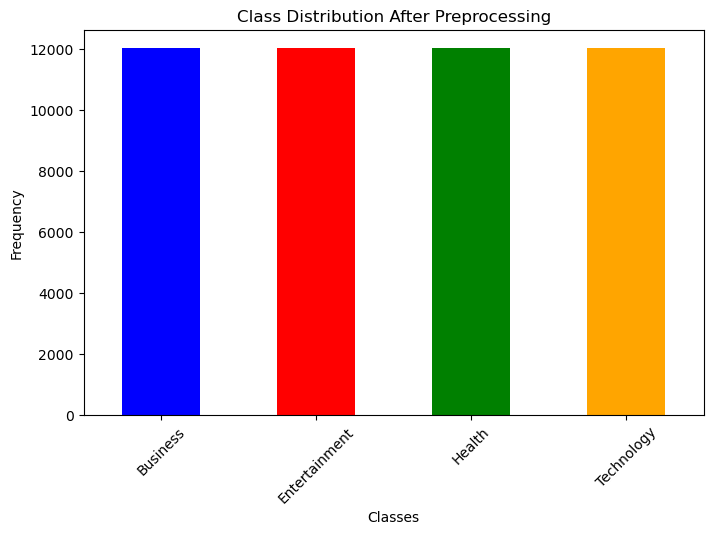

In [11]:
# Count each class after balancing
print("Final class distribution after preprocessing:")
print(train_df['Label'].value_counts())

# Plot class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
train_df['Label'].value_counts().plot(kind='bar', color=['blue', 'red', 'green', 'orange'])
plt.title("Class Distribution After Preprocessing")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [13]:
# Encode labels
label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])

print(f"Labels encoded! Unique classes: {len(label_encoder.classes_)}")

Labels encoded! Unique classes: 4


In [15]:
from sklearn.model_selection import GridSearchCV

# Define a Pipeline for SVM with BoW
svm_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=10000)),  # BoW feature extraction
    ('classifier', SVC(class_weight='balanced', random_state=42))  # SVM Classifier
])

# Define the parameter grid for SVM
svm_param_grid = {
    'vectorizer__max_features': [5000, 10000],  # Number of words in BoW
    'vectorizer__ngram_range': [(1,1), (1,2)],  # Unigrams and bigrams
    'classifier__C': [10, 100],  # Regularization parameter
    'classifier__kernel': ['rbf'],  # Kernel type
    'classifier__gamma': ['auto', 'scale']  # Kernel coefficient for rbf
}


In [17]:
# Use a subset to speed up Grid Search
subset_size = 1  # % of dataset for tuning
train_subset = train_df.sample(frac=subset_size, random_state=42)

X = train_subset['Combined']
y = train_subset['Label']

# Define Grid Search
svm_grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,  # 5-Fold Cross Validation
    verbose=2,
    n_jobs=-1  # Use all CPU cores for faster processing
)

# Fit the Grid Search
print("Performing Grid Search...")
svm_grid_search.fit(X, y)


# Get all results from GridSearchCV
results = pd.DataFrame(svm_grid_search.cv_results_)

# Sort by mean test score (descending order)
top_10_results = results.sort_values(by="mean_test_score", ascending=False).head(10)

# Select relevant columns
top_10_params = top_10_results[["params", "mean_test_score", "std_test_score"]]

# Print results
# Print top 10 Grid Search results in a readable format
print(top_10_params.to_string(index=False))

# Output the best parameters and score
print("Best Parameters for SVM:", svm_grid_search.best_params_)
print("Best Cross-Validation Accuracy for SVM:", svm_grid_search.best_score_)


Performing Grid Search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END classifier__C=10, classifier__gamma=auto, classifier__kernel=rbf, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 6.1min
[CV] END classifier__C=10, classifier__gamma=auto, classifier__kernel=rbf, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 6.2min
[CV] END classifier__C=10, classifier__gamma=auto, classifier__kernel=rbf, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 6.2min
[CV] END classifier__C=10, classifier__gamma=auto, classifier__kernel=rbf, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 6.2min
[CV] END classifier__C=10, classifier__gamma=auto, classifier__kernel=rbf, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 6.2min
[CV] END classifier__C=10, classifier__gamma=auto, classifier__kernel=rbf, vectorizer__max_features=5000, vectorizer__ngram_rang

In [33]:
# Define a Pipeline for Random Forest with BoW
rf_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=10000)),  # BoW feature extraction
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=None))  # Random Forest Classifier
])

# Define the parameter grid for Random Forest
rf_param_grid = {
    'vectorizer__max_features': [5000, 10000],  # Number of words in BoW
    'vectorizer__ngram_range': [(1,1), (1,2)],  # Unigrams and bigrams
    'classifier__n_estimators': [100, 200],  # Number of trees
    'classifier__max_depth': [None, 10, 20],  # Tree depth
    'classifier__min_samples_split': [2, 5],  # Minimum samples to split
    'classifier__min_samples_leaf': [1, 2],  # Minimum samples per leaf
}

In [35]:
# Use a subset to speed up Grid Search
subset_size = 1
train_subset = train_df.sample(frac=subset_size, random_state=None)

X = train_subset['Combined']
y = train_subset['Label']

# Define Grid Search
rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,  # 5-Fold Cross Validation
    verbose=2,
    n_jobs=-1  # Use all CPU cores for faster processing
)

# Fit the Grid Search
print("Performing Grid Search for Random Forest...")
rf_grid_search.fit(X, y)

# Get all results from GridSearchCV
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

# Sort by mean test score (descending order)
top_10_rf_results = rf_results.sort_values(by="mean_test_score", ascending=False).head(10)

# Select relevant columns
top_10_rf_params = top_10_rf_results[["params", "mean_test_score", "std_test_score"]]

# Print top 10 Grid Search results in a readable format
print(top_10_rf_params.to_string(index=False))

# Output the best parameters and score
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best Cross-Validation Accuracy for Random Forest:", rf_grid_search.best_score_)

Performing Grid Search for Random Forest...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 1.2min
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 1.2min
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 1.2min
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 1.2min
[CV] END classifier__max_depth=None, c

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time= 2.0min
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time= 2.0min
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 2.6min
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 2.5min
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200, vectorizer

In [49]:
# Define a Pipeline for SVM with BoW
svm_line_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=10000)),  # BoW feature extraction
    ('classifier', SVC(class_weight='balanced', random_state=None))  # SVM Classifier
])

# Define the parameter grid for SVM
svm_line_param_grid = {
    'vectorizer__max_features': [5000, 10000],  # Number of words in BoW
    'vectorizer__ngram_range': [(1,1), (1,2)],  # Unigrams and bigrams
    'classifier__C': [0.1, 1, 10, 100],  # Regularization parameter
    'classifier__kernel': ['linear'],  # Kernel type
    #'classifier__gamma': ['auto', 'scale']  # Kernel coefficient for rbf
}


In [51]:
# Use a subset to speed up Grid Search
subset_size = 1 
train_subset = train_df.sample(frac=subset_size, random_state=42)

X = train_subset['Combined']
y = train_subset['Label']

# Define Grid Search
svm_line_grid_search = GridSearchCV(
    estimator=svm_line_pipeline,
    param_grid=svm_line_param_grid,
    cv=5,  # 5-Fold Cross Validation
    verbose=2,
    n_jobs=-1  # Use all CPU cores for faster processing
)

# Fit the Grid Search
print("Performing Grid Search...")
svm_line_grid_search.fit(X, y)


# Get all results from GridSearchCV
line_results = pd.DataFrame(svm_line_grid_search.cv_results_)

# Sort by mean test score (descending order)
line_top_10_results = line_results.sort_values(by="mean_test_score", ascending=False).head(10)

# Select relevant columns
line_top_10_params = line_top_10_results[["params", "mean_test_score", "std_test_score"]]

# Print results
# Print top 10 Grid Search results in a readable format
print(line_top_10_params.to_string(index=False))

# Output the best parameters and score
print("Best Parameters for SVM_line:", svm_line_grid_search.best_params_)
print("Best Cross-Validation Accuracy for SVM_line:", svm_line_grid_search.best_score_)


Performing Grid Search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END classifier__C=0.1, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 5.1min
[CV] END classifier__C=0.1, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 5.1min
[CV] END classifier__C=0.1, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 5.2min
[CV] END classifier__C=0.1, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 5.3min
[CV] END classifier__C=0.1, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time= 5.3min
[CV] END classifier__C=0.1, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time= 5.8min
[CV] END classifier__C=0.1, classifier__kernel=linear, vectorizer__max_features=5000, vecto

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__C=100, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=17.4min
[CV] END classifier__C=100, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time= 5.2min
[CV] END classifier__C=100, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time= 5.6min
[CV] END classifier__C=100, classifier__kernel=linear, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time= 5.3min
[CV] END classifier__C=100, classifier__kernel=linear, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time= 5.5min
[CV] END classifier__C=100, classifier__kernel=linear, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time= 5.3min
[CV] END classifier__C=100, classifier__kernel=linear, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time= 5.2min
[CV] END classifier__C=100, classifier